# Rekurencyjne sieci neuronowe (II)

## Warstwa LSTM

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Architektura sieci:

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(10000, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

Kompilacja modelu:

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Trenowanie utworzonego modelu sieci:

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5768 - loss: 0.6710 - val_accuracy: 0.7120 - val_loss: 0.5504
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.8182 - loss: 0.4232 - val_accuracy: 0.8596 - val_loss: 0.3379
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.8628 - loss: 0.3357 - val_accuracy: 0.8784 - val_loss: 0.3067
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.8765 - loss: 0.3035 - val_accuracy: 0.8798 - val_loss: 0.2955
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.8898 - loss: 0.2704 - val_accuracy: 0.8754 - val_loss: 0.3010
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9073 - loss: 0.2440 - val_accuracy: 0.8790 - val_loss: 0.3281
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9158 - loss: 0.2219 - val_accuracy: 0.8176 - val_loss: 0.5484
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9173 - loss: 0

Wykresy dokładności oraz straty trenowania i walidacji:

In [ ]:
from matplotlib import pyplot as plt

def plot_history(history_dict):
  training_loss = history_dict['loss']
  validation_loss = history_dict['val_loss']

  training_accuracy = history_dict['accuracy']
  validation_accuracy = history_dict['val_accuracy']

  plt.figure(figsize = (12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(training_loss)
  plt.plot(validation_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(training_accuracy)
  plt.plot(validation_accuracy)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')

  plt.tight_layout()
  plt.show()

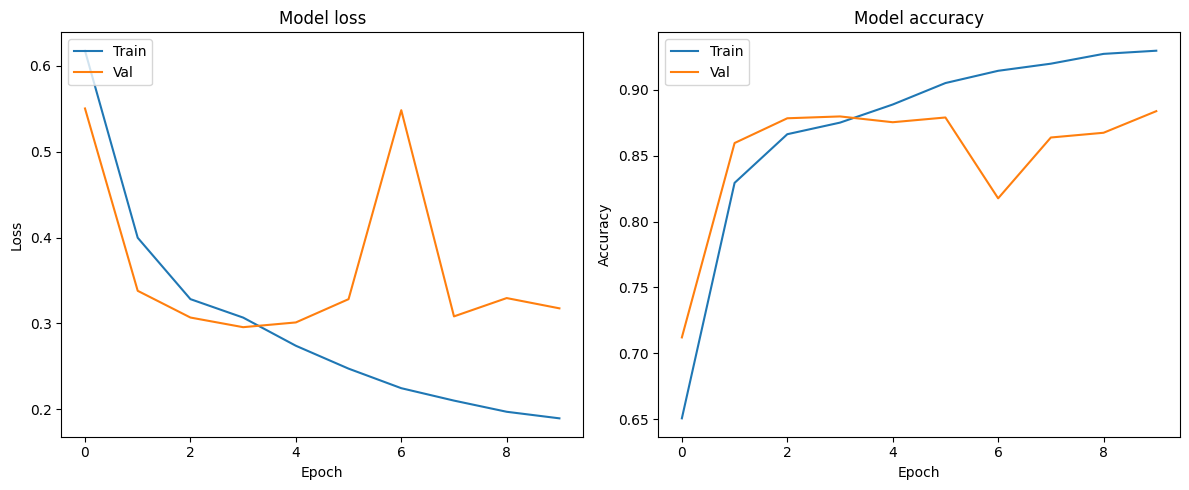

In [ ]:
history_dict = history.history

plot_history(history_dict)

Wyniki dla sieci z SimpleRNN z poprzedniego laboratorium (znacznie lepsze wyniki dla modelu z LSTM):

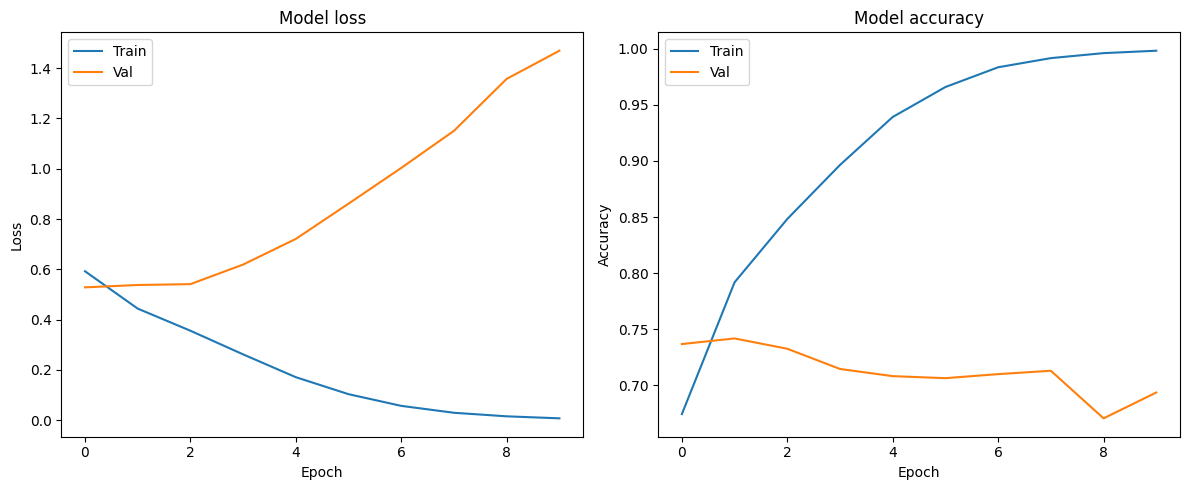

In [ ]:
# history_dict = history.history

# plot_history(history_dict)

## Analiza szeregu czasowego (Time Series)

### Zbiór danych pogodowych – najważniejsze informacje

In [ ]:
csv_file = open('./jena_climate_2009_2016.csv')
data = csv_file.read()
csv_file.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

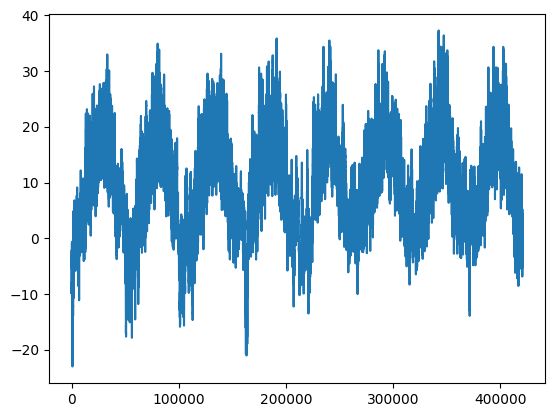

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] # Temperatura (stopnie Celsjusza)
plt.plot(range(len(temp)), temp)
plt.show()

Przygotuj wykres zmian temperatury w ciągu pierwszych dziesięciu dni ujętych w badanym zbiorze:

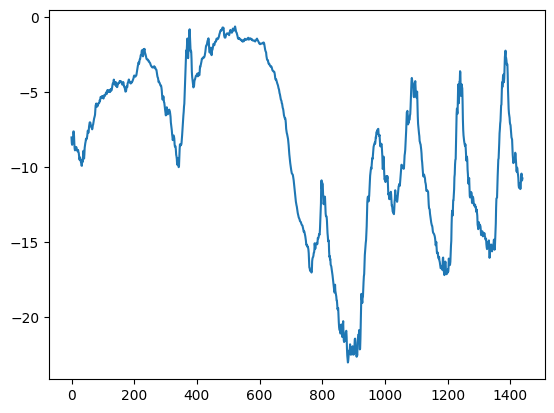

In [ ]:
temp_10_days = float_data[:144*10, 1]
plt.plot(range(len(temp_10_days)), temp_10_days)
plt.show()

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [ ]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

# Liczba kroków pobierania danych z obiektu val_gen
# zapewniających przetworzenie całego walidacyjnego zbioru danych.
val_steps = (300000 - 200001 - lookback) // batch_size

# Liczba kroków pobierania danych z obiektu test_gen,
# przy której przetworzony zostanie cały testowy zbiór danych.
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
# model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Input(shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

Wyrenuj model (20 epok):

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=test_steps,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1.7381 - val_loss: 0.4701
Epoch 2/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3465 - val_loss: 0.3471
Epoch 3/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2633 - val_loss: 0.3245
Epoch 4/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2422 - val_loss: 0.3173
Epoch 5/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2295 - val_loss: 0.3176
Epoch 6/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2223 - val_loss: 0.3246
Epoch 7/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.2148 - val_loss: 0.3241
Epoch 8/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2099 - val_loss: 0.3283
Epoch 9/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2068 - val_loss: 0.3373
Epoch 10/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.2011 - val_loss: 0.3339
Epoch 11/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.2000 - val_loss: 0.3289
Epoch 12/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 9s 1

Opracuj wykresy strat:

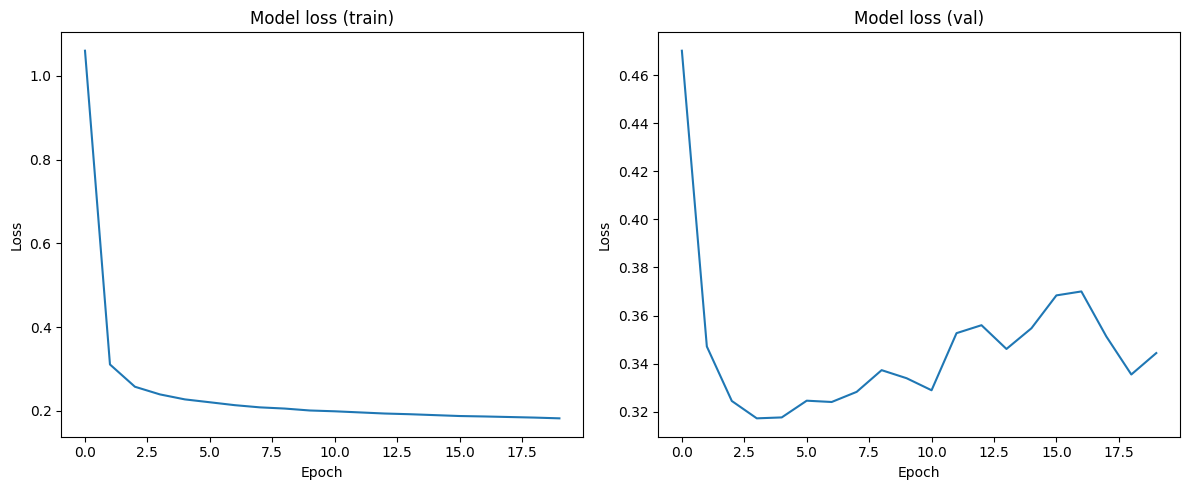

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss)
plt.title('Model loss (train)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(val_loss)
plt.title('Model loss (val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

## Warstwa GRU

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
# model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Input(shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

Wyrenuj model (20 epok):

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=test_steps,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - loss: 0.3241 - val_loss: 0.2673
Epoch 2/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 60s 65ms/step - loss: 0.2815 - val_loss: 0.2667
Epoch 3/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - loss: 0.2721 - val_loss: 0.2659
Epoch 4/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - loss: 0.2641 - val_loss: 0.2652
Epoch 5/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 61s 66ms/step - loss: 0.2586 - val_loss: 0.2742
Epoch 6/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 61s 66ms/step - loss: 0.2505 - val_loss: 0.2769
Epoch 7/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - loss: 0.2429 - val_loss: 0.2742
Epoch 8/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 60s 65ms/step - loss: 0.2339 - val_loss: 0.2824
Epoch 9/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 61s 66ms/step - loss: 0.2265 - val_loss: 0.2862
Epoch 10/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - loss: 0.2197 - val_loss: 0.2960
Epoch 11/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - loss: 0.2124 - val_loss: 0.2954
Epoch 12/20
929/929 ━━━━━━━━━━

Opracuj wykresy strat:

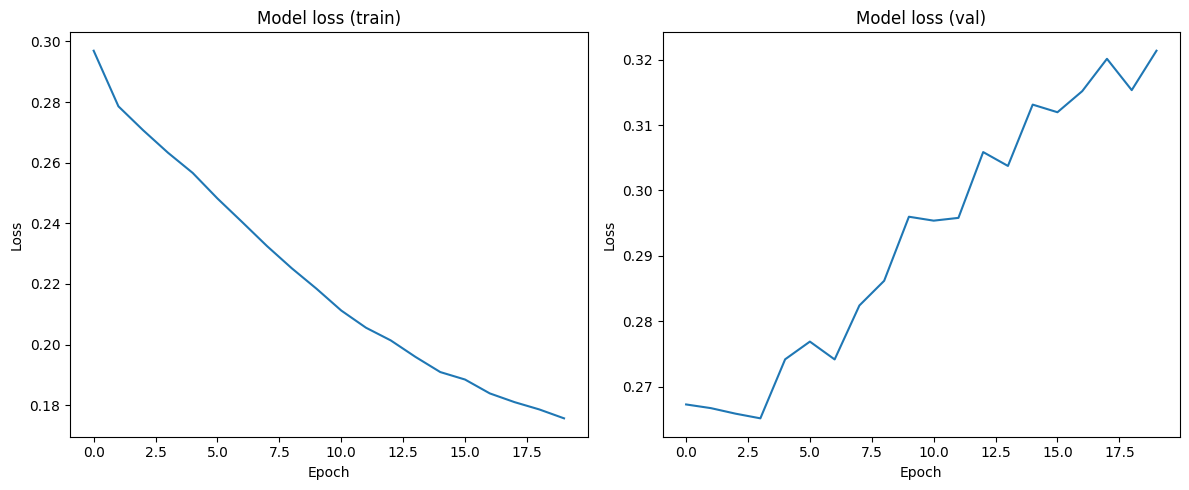

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss)
plt.title('Model loss (train)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(val_loss)
plt.title('Model loss (val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

## Dwukierunkowe sieci rekurencyjne

### Tworzenie instancji dwukierunkowej sieci rekurencyjnej

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
# model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Input(shape=(None, float_data.shape[-1])))
model.add(layers.Bidirectional(layers.GRU(32)))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

Wytrenuj model (40 epok):

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=test_steps,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - loss: 0.3123 - val_loss: 0.2676
Epoch 2/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - loss: 0.2708 - val_loss: 0.2675
Epoch 3/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 79s 85ms/step - loss: 0.2611 - val_loss: 0.2710
Epoch 4/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 84s 90ms/step - loss: 0.2504 - val_loss: 0.2685
Epoch 5/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 83s 89ms/step - loss: 0.2397 - val_loss: 0.2841
Epoch 6/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 78s 84ms/step - loss: 0.2298 - val_loss: 0.2845
Epoch 7/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 78s 84ms/step - loss: 0.2182 - val_loss: 0.2915
Epoch 8/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - loss: 0.2070 - val_loss: 0.3018
Epoch 9/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 77s 83ms/step - loss: 0.1955 - val_loss: 0.3130
Epoch 10/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 80s 86ms/step - loss: 0.1868 - val_loss: 0.3156
Epoch 11/40
929/929 ━━━━━━━━━━━━━━━━━━━━ 80s 86ms/step - loss: 0.1777 - val_loss: 0.3252
Epoch 12/40
929/929 ━━━━━━━━━━

Dokonaj analizy uzyskanych wyników:

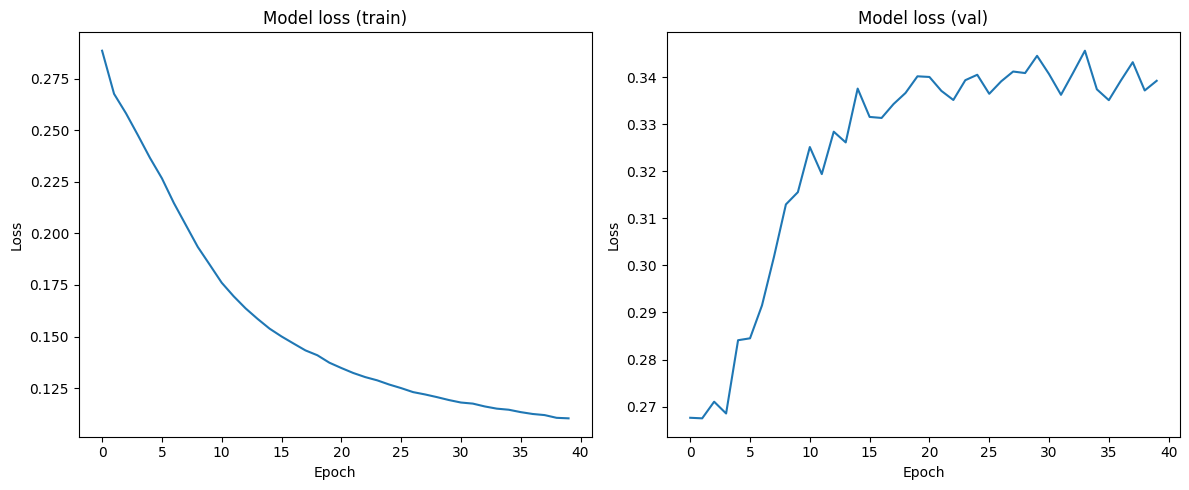

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss)
plt.title('Model loss (train)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(val_loss)
plt.title('Model loss (val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

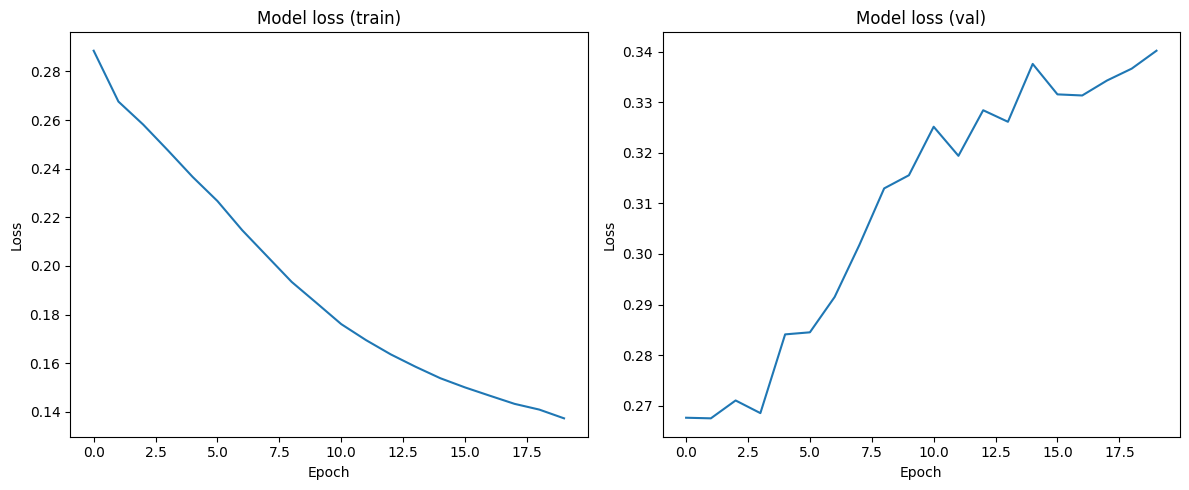

In [ ]:
loss = history.history['loss'][:20]
val_loss = history.history['val_loss'][:20]

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss)
plt.title('Model loss (train)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(val_loss)
plt.title('Model loss (val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()